<a href="https://colab.research.google.com/github/lanpty58/mystudy/blob/main/CNN_Basic_Classification_(MNIST_Dataset).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchsummary import summary
import matplotlib.pyplot as plt
from PIL import Image

root = './data'
train_datas = datasets.MNIST(root = root, train = True, download = True)
test_data = datasets.MNIST(root = root, train = False, download = True)


In [2]:
#Pre-processing data
valid_ratio = 0.9
n_train_examples = int(len(train_datas)*valid_ratio)
n_valid_examples = len(train_datas) - n_train_examples
train_data, valid_data = data.random_split(train_datas, [n_train_examples, n_valid_examples])
print(len(train_data), len(valid_data))

54000 6000


In [3]:
#Compute mean and std for normalization
mean = train_data.dataset.data.float().mean()/255
std = train_data.dataset.data.float().std()/255

train_transforms = transforms.Compose([
      transforms.ToTensor(), transforms.Normalize(mean = [mean], std = [std])
])
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean = [mean], std = [std])
])
train_data.dataset.transform = train_transforms
valid_data.dataset.transform = test_transforms

In [4]:
BATCH_SIZE = 256
train_dataloader = data.DataLoader(train_data, shuffle = True, batch_size = BATCH_SIZE)
valid_dataloader = data.DataLoader(valid_data, batch_size = BATCH_SIZE)


In [5]:
class LeNetClassifier(nn.Module):
  def __init__(self, num_classes):
    super().__init__()
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, padding = 'same')
    self.avgpool1 = nn.AvgPool2d(kernel_size=2)
    self.conv2 = nn.Conv2d(in_channels = 6, out_channels= 16, kernel_size = 5)
    self.avgpool2 = nn.AvgPool2d(2)
    self.flatten = nn.Flatten()
    self.fc1 = nn.Linear(400, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, num_classes)

  def forward(self, inputs):
    outputs = self.conv1(inputs)
    outputs = self.avgpool1(outputs)
    outputs = F.relu(outputs)
    outputs = self.conv2(outputs)
    outputs = self.avgpool2(outputs)
    outputs = F.relu(outputs)
    outputs = self.flatten(outputs)
    # print(outputs.shape)
    outputs = self.fc1(outputs)
    outputs = self.fc2(outputs)
    outputs = self.fc3(outputs)
    return outputs


In [6]:
import time
def train(model, optimizer, criterion, train_dataloader, device, epoch = 0, log_interval = 50):
  model.train()
  total_acc, count = 0, 0
  losses = []
  start_time = time.time()
  for idx, (inputs, labels) in enumerate(train_dataloader):
    inputs, labels = inputs.to(device), labels.to(device)
    predictions = model(inputs)
    loss = criterion(predictions, labels)
    losses.append(loss.item())
    total_acc += (predictions.argmax(1) == labels).sum().item()
    count+= len(labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  acc = total_acc/count
  loss = sum(losses)/len(losses)
  return acc, loss

In [7]:
def evaluation(model, criterion, dataloader, device, epoch =0, log_interval = 50):
  model.eval()
  total_acc, count = 0, 0
  losses = []
  with torch.no_grad():
    for idx, (inputs, labels) in enumerate(dataloader):
      inputs, labels = inputs.to(device), labels.to(device)
      predictions = model(inputs)
      loss = criterion(predictions, labels)
      total_acc += (predictions.argmax(1) == labels).sum().item()
      losses.append(loss.item())
      count += len(labels)
  acc = total_acc/count
  loss = sum(losses)/len(losses)
  return acc, loss

In [8]:
import torch.optim as optim
num_classes = len(train_data.dataset.classes)
device = torch.device('cuda' if torch.cuda.is_available() else 'gpu')
lenet_model = LeNetClassifier(num_classes)
lenet_model.to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(lenet_model.parameters(), lr = 0.01)


In [9]:
num_epochs = 20

train_accs, train_losses = [], []
val_accs, val_losses = [], []
best_loss_eval = 100
for epoch in range(num_epochs):
  train_acc, train_loss = train(lenet_model, optimizer, criterion, train_dataloader, device, epoch)
  train_accs.append(train_acc)
  train_losses.append(train_loss)
  eval_acc, eval_loss = evaluation(lenet_model, criterion, valid_dataloader, device, epoch)
  val_accs.append(eval_acc)
  val_losses.append(eval_loss)

  if eval_loss < best_loss_eval:
    best_loss_eval = eval_loss
    torch.save(lenet_model.state_dict(), './lenet_model.pt')

  print(f'Epoch: {epoch} | Train Acc: {train_acc:.3f}, Train Loss: {train_loss:.3f}, Val Acc:{eval_acc: .3f}, Val Loss: {eval_loss:.3f}')


Epoch: 0 | Train Acc: 0.921, Train Loss: 0.248, Val Acc: 0.973, Val Loss: 0.083
Epoch: 1 | Train Acc: 0.973, Train Loss: 0.089, Val Acc: 0.971, Val Loss: 0.097
Epoch: 2 | Train Acc: 0.977, Train Loss: 0.077, Val Acc: 0.977, Val Loss: 0.090
Epoch: 3 | Train Acc: 0.978, Train Loss: 0.071, Val Acc: 0.977, Val Loss: 0.079
Epoch: 4 | Train Acc: 0.980, Train Loss: 0.069, Val Acc: 0.972, Val Loss: 0.108
Epoch: 5 | Train Acc: 0.979, Train Loss: 0.071, Val Acc: 0.973, Val Loss: 0.090
Epoch: 6 | Train Acc: 0.981, Train Loss: 0.062, Val Acc: 0.981, Val Loss: 0.065
Epoch: 7 | Train Acc: 0.982, Train Loss: 0.061, Val Acc: 0.979, Val Loss: 0.074
Epoch: 8 | Train Acc: 0.981, Train Loss: 0.062, Val Acc: 0.974, Val Loss: 0.088
Epoch: 9 | Train Acc: 0.981, Train Loss: 0.063, Val Acc: 0.980, Val Loss: 0.087
Epoch: 10 | Train Acc: 0.985, Train Loss: 0.051, Val Acc: 0.978, Val Loss: 0.079
Epoch: 11 | Train Acc: 0.985, Train Loss: 0.050, Val Acc: 0.977, Val Loss: 0.078
Epoch: 12 | Train Acc: 0.982, Train Lo

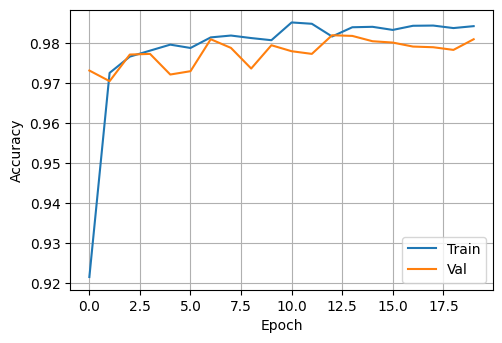

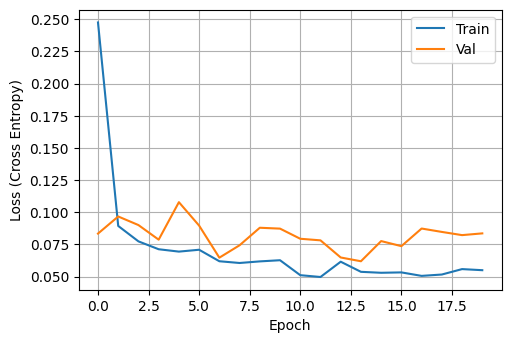

In [28]:
import matplotlib.pyplot as plt
figure = plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.plot(train_accs, label = 'Train')
plt.plot(val_accs, label = 'Val')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.grid(True)
plt.legend()
plt.show()

figure = plt.figure(figsize=(12, 8))
plt.subplot(2,2,2)
plt.plot(train_losses, label = 'Train')
plt.plot(val_losses, label = 'Val')
plt.ylabel('Loss (Cross Entropy)')
plt.xlabel('Epoch')
plt.grid(True)
plt.legend()
plt.show()